[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kasparvonbeelen/ghi_python/main?labpath=11_-_Linear_Regression.ipynb)


# Lecture 11: Correlation and Linear Regression
## A gentle introduction to correlation and regression for historians 
### ... in Python and Pandas


## Data Science for Historians (with Python)

### Created by Kaspar Beelen and Luke Blaxill

### For the German Historical Institute, London

<img align="left" src="https://www.ghil.ac.uk/typo3conf/ext/wacon_ghil/Resources/Public/Images/institute_icon_small.png">



This notebook turns to more advanced and scientifically interesting methods. We will discuss linear regression and later on generalised linear models. 

So far, we focused on quantifying and interpreting differences between subgroups in our data (place and gender), more specifically estimating the significance between the means.


Now we turn the analysing the relationship between variables, the extent to which variables are associated with each other. This allows us to model historical phenomena and make predictions. 

As in the previous notebook, we highly recommend you watch the lecture by Luke Blaxill for an introduction to the concepts and terminology used in this lecture.

## Understanding relations between variables: Lifespan and Wealth in late Victorian London

We continue with the data used previously but change the research question and analyse the relationship between wealth and lifespan. Concretely, we will asess if the wealthier districts causes a higher ratio of older people. We don't have information on the possession or income for each individual but we have access to the rateable value per capita for each borough in London, which serves as a proxy for the average prosperity of place. We will abbreviate this variable as `rvc` in what follows. 

When it comes to lifespan we use the same synthetic census data as in notebook ten. We don't have information on how long people live, but we can establish the ratio of 'old' people, for example, those aged over 50. 

Notice how both variables (wealth and lifespan) are proxies for concepts we can not measure directly. In many ways, this makes this case study highly problematic (but therefore morer useful from a didactic perspective). However, working with imperfect proxies is often the only option and being creative with your data is a necessity. In the social sciences, the operationalisation of your research is called [construct validity](https://en.wikipedia.org/wiki/Construct_validity): as we project meaning onto our data we should be critical of our semantics.



Let's turn to our code. The first step is to load the required tools we need later on in this notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set()

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Before turning to the actual regression analysis, we need to discuss the data wrangling. We will cover a few steps that you will often encounter when preparing your data for analysis.

We create a new dataframe that records the ratio of people over 50 for each district. 

Why? We don't know how long Londoners live on average. Here we reason that districts where people have a higher probability of getting "old" (beyond 50) they tend to live longer. For "old", we computed the ratio of residents over 50 years (twice the median) but we could have chosen other thresholds. We encourage you to do this and assess the extent to which the results will change.

In [2]:
!ls data/icem/

EW01_london_sample.csv      EW01_selected.csv
EW01_london_subsample.csv   EW01_selected_sample.csv
EW01_london_subsample_2.csv rateable_value.csv


In [3]:
df = pd.read_csv('data/icem/EW01_london_subsample_2.csv',index_col=0)
df.head()

,RegDist,SubDist,Sex,Age
2402205,St George In The East,St George North,M,42
3065353,St Olave Southwark,Bermondsey,F,56
2972022,Southwark,St Mary Newington,F,44
2121692,Shoreditch,Hoxton Old Town,M,40
2225893,Bethnal Green,Bethnal Green North,F,5


In [4]:
df.Age.mean(), df.Age.median()

(27.74792555804773, 25.0)

In [5]:
#age_by_dist = df.groupby(['RegDist']).agg({'Age':'mean','Sex':'count'})

In [6]:
age_by_dist = df.groupby(['RegDist','SubDist']).agg({'Age':lambda x: round(np.mean(x > 50) *100,1),'Sex':'count'}).reset_index()

In [7]:
age_by_dist

,RegDist,SubDist,Age,Sex
0,Bethnal Green,Bethnal Green East,13.7,10826
1,Bethnal Green,Bethnal Green North,10.6,12570
2,Bethnal Green,Bethnal Green South,9.6,8121
3,Camberwell,Camberwell,14.7,22260
4,Camberwell,Dulwich,14.5,2491
...,...,...,...,...
109,Whitechapel,Spitalfields,9.4,6659
110,Woolwich,Charlton,11.9,5220
111,Woolwich,Plumstead East,10.7,12100
112,Woolwich,Plumstead West,13.9,4444


To understand the relationship between average wealth and lifespan we need to add additional information to our dataframe. 

The dataframe below capture the rateable value per capita in each London borough (these data are synthetic but follow the pattern of  "real" values collected for 1922).

In [8]:
rvc = pd.read_csv('./data/icem/rateable_value.csv',index_col=0)
rvc.head()

,borough,rateable_value_pc
0,Battersea,6.1
1,Bermondsey,8.5
2,Bethnal Green,4.9
3,Camberwell,5.2
4,Chelsea,14.7


We want to merge the data frames, but first, we should check to what extent this is possible, both practically and theoretically.

Our first question is: What variables occur in both datasets? Which ones can we use to combine information from different sources?

For our data, both data frames have information about place. The census lists registration districts while the rateable value is organised by the borough.

This leads to a second question: To what extent are the districts that appear in the census the same as the boroughs in the data on rateable value per capita?

First we want check which place names appear in both datasets. We create a Python `set`, a list of unique values, for the place names in both dataframes.


In [9]:
d1_pl = set(df['RegDist'])
print(d1_pl)

{'London City', 'Stepney', 'Wandsworth', 'St George Hanover Square', 'Lambeth', 'Poplar', 'Fulham', 'Lewisham', 'Strand', 'Paddington', 'Bethnal Green', 'Whitechapel', 'St Olave Southwark', 'Hackney', 'Hampstead', 'Woolwich', 'Southwark', 'Marylebone', 'St George In The East', 'Westminster', 'Kensington', 'Pancras', 'Holborn', 'St Giles', 'Greenwich', 'Chelsea', 'Shoreditch', 'Islington', 'Camberwell', 'Mile End Old Town'}


In [10]:
d2_pl = set(rvc['borough'])
print(d2_pl)

{'Stepney', 'Wandsworth', 'Lambeth', 'Poplar', 'Fulham', 'Lewisham', 'Paddington', 'Hammersmith', 'Bethnal Green', 'Hackney', 'Stoke Newington', 'Hampstead', 'Woolwich', 'Southwark', 'Marylebone', 'Kensington', 'Finsbury', 'Pancras', 'Holborn', 'Greenwich', 'Battersea', 'Chelsea', 'Deptford', 'Shoreditch', 'Islington', 'Camberwell', 'Bermondsey', 'Westminster'}


We then compute the intersection of these two sets, i.e. the names that appear in both dataframes.

The syntax is `set1.intersection(set2)`. We basically apply the `.intersection()` to a set and pass another set as argument.

In [11]:
print(d1_pl.intersection(d2_pl)) # place names that appear in both dataframes

{'Stepney', 'Wandsworth', 'Lambeth', 'Poplar', 'Fulham', 'Lewisham', 'Paddington', 'Bethnal Green', 'Hackney', 'Hampstead', 'Woolwich', 'Southwark', 'Marylebone', 'Kensington', 'Pancras', 'Holborn', 'Greenwich', 'Chelsea', 'Shoreditch', 'Islington', 'Camberwell', 'Westminster'}


In [12]:
d1_pl - d2_pl # place names that appear in df and not rvc

{'London City',
 'Mile End Old Town',
 'St George Hanover Square',
 'St George In The East',
 'St Giles',
 'St Olave Southwark',
 'Strand',
 'Whitechapel'}

In [13]:
d2_pl - d1_pl # place names that appear in rvc and not in df

{'Battersea',
 'Bermondsey',
 'Deptford',
 'Finsbury',
 'Hammersmith',
 'Stoke Newington'}

We can merge these two data frame based on the place names. However, be careful: it is not because the strings match that they mean the same thing!

Don't worry about the syntax we will explain it in more detail below.

In [14]:
data_merged = age_by_dist.merge(rvc,left_on='RegDist',right_on='borough')
data_merged

,RegDist,SubDist,Age,Sex,borough,rateable_value_pc
0,Bethnal Green,Bethnal Green East,13.7,10826,Bethnal Green,4.9
1,Bethnal Green,Bethnal Green North,10.6,12570,Bethnal Green,4.9
2,Bethnal Green,Bethnal Green South,9.6,8121,Bethnal Green,4.9
3,Camberwell,Camberwell,14.7,22260,Camberwell,5.2
4,Camberwell,Dulwich,14.5,2491,Camberwell,5.2
...,...,...,...,...,...,...
89,Westminster,St James Westminster,14.1,5317,Westminster,57.2
90,Woolwich,Charlton,11.9,5220,Woolwich,6.6
91,Woolwich,Plumstead East,10.7,12100,Woolwich,6.6
92,Woolwich,Plumstead West,13.9,4444,Woolwich,6.6


`.merge()` is an extremely useful method combining data frames. It requires us to specify which variable (or column) is shared across data frames and can be used for merging tables. 


In this `.merge()` operation, we combined information from `rvc` with `age_by_dist`. 

As we have shown before, both data frames contain a column with similar values, namely, place names in London. 

We use these values to combine the data frames, i.e. rows that have the value `Bethnal Green` in the `age_by_dist` data frames will be joined by the information we have for 'Bethnal Green' in `rvc`

Please notice: the names of the columns can be different but the values in the columns have to overlap.

Below we show a toy example slight adapted from very thorough Pandas [documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).

Imagine that I recorded the number of cats and dogs I spotted each day, but kept this information in two separate data frames.

In [15]:
df1 = pd.DataFrame({'day': ['mon', 'tue', 'wed', 'thu'],
                    'cats': [1, 2, 3, 5]})
df2 = pd.DataFrame({'dayz': ['mon', 'tue', 'wed', 'thu'],
                    'dogs': [5, 6, 7, 8]})

In [16]:
df1

,day,cats
0,mon,1
1,tue,2
2,wed,3
3,thu,5


In [17]:
df2

,dayz,dogs
0,mon,5
1,tue,6
2,wed,7
3,thu,8


Both tables have a column that records that day of the week, even though the column name is slightly differentz. We can combine these data frames into one using `left_df.merge(right_df)`. The method is applied to a dataframe at the left-hand side (before the dot) and one at the right-hand side (passed as an argument to the method).

To merge properly, we have to instruct Pandas precisely which columns we want to use for combining information. `left_on` (`right_on`) indicates the column name we use in the dataframe at the left-hand (right-hand) side of the `.merge()` method. 

In [18]:
df1.merge(df2, left_on='day', right_on='dayz')

,day,cats,dayz,dogs
0,mon,1,mon,5
1,tue,2,tue,6
2,wed,3,wed,7
3,thu,5,thu,8


Sometimes we want `.merge()` using the index of a data frame instead of a column. In this case, we select the argument `left_index` (or `right_index`) and which takes a boolean value (`True` or `False`).

The `.merge()` operation should be more understandable at this point: we merge `age_by_dist` (left) with `rvc`. For the left data frame we use the index (`left_index=True`), for the right the `'borough'` column  (`right_on='borough'`).

In [19]:
data_merged = age_by_dist.merge(rvc,left_on='RegDist',right_on='borough')
data_merged.head()

,RegDist,SubDist,Age,Sex,borough,rateable_value_pc
0,Bethnal Green,Bethnal Green East,13.7,10826,Bethnal Green,4.9
1,Bethnal Green,Bethnal Green North,10.6,12570,Bethnal Green,4.9
2,Bethnal Green,Bethnal Green South,9.6,8121,Bethnal Green,4.9
3,Camberwell,Camberwell,14.7,22260,Camberwell,5.2
4,Camberwell,Dulwich,14.5,2491,Camberwell,5.2


In [20]:
data_merged.drop('RegDist',inplace=True, axis=1)
data_merged.head()

,SubDist,Age,Sex,borough,rateable_value_pc
0,Bethnal Green East,13.7,10826,Bethnal Green,4.9
1,Bethnal Green North,10.6,12570,Bethnal Green,4.9
2,Bethnal Green South,9.6,8121,Bethnal Green,4.9
3,Camberwell,14.7,22260,Camberwell,5.2
4,Dulwich,14.5,2491,Camberwell,5.2


##  Correlation

After combining information from these two data frames, we can explore the relationship between variables. Let's start with the most obvious: correlation. 

Correlation tells us the extent to which two variables are related. Imagine, each day I collect the number of dogs and cats I observed in two separate variables or vectors (`dogs` and `cats`). 

If there is a correlation, I expect that if the number of (spotted) dogs up, the same will apply to cats.

Visually, we can make a scatterplot to assess whether there is a correlation: the x-axis shows the number of dogs, the y-axis the number of cats. 

In [21]:
dogs = [1,3,5,7,2,6] # first vector
cats = [2,4,8,7,3,5] # second vector

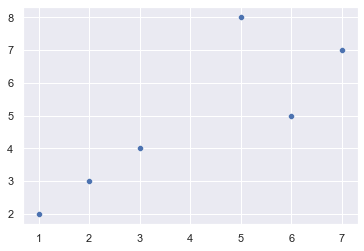

In [22]:
sns.scatterplot(x=dogs,y=cats)

The figure suggests a strong correlation between the vectors for`dogs` and `cats`, i.e. we observe high values for y when x is high (and vice versa of course). 

Please notice that computing correlation is based on an implicit alignment between the two vectors. Each position captures the same day. If the order in `cats` would be different from `dogs` (for example the former starts on Wednesday and the latter on Sunday) I could, technically, still make a scatterplot and computer correlation but the results would be meaningless (or at least not match the intention).

The visualization is helpful, but we'd like to put a number on this, quantify the strength of the relation, so we can compare if other vectors are stronger correlated. Here the Pearson correlation coefficient will come to our rescue.




### Pearson Correlation

A widely used measure for computing the relationship between two vectors or vectors is the Pearson correlation coefficient. This coefficient will vary between -1 and +1, meaning a strong negative respectively positive correlation. A score of 0 indicates no correlation.

We will first show you how to compute the Pearson correlation coefficient yourself, purely for didactic purposes, so you know what is going on (the score is not magic, far from!). But as you can probably guess by this point, there exists a method in Pandas that will help you. We'll have a look at that later.

Showing how the calculation is done, demystifies the process and helps you to understand what is going on.

We need a few ingredients to compute the Pearson correlation coefficient. First, we calculate the mean and standard deviation for each vector. We need to normalize by the amount of data we have and record the number of observations  `n`, which is equal to the length of `v1` (or `v2`—remember both are aligned and equal in length!).

In [23]:
v1 = [1,3,5,7,2,6] # first vector
v2 = [2,4,8,7,3,5] # second vector

In [24]:
mean_v1 = np.mean(v1)
mean_v2 = np.mean(v2)
std_v1 = np.std(v1)
std_v2 = np.std(v2)
n = len(v1)

Next, we subtract each value a vector with the mean (of that vector of course). We repeat this for `v1` and `v2`.

In [25]:
sub_mean_v1 = [i - mean_v1 for i in v1]
sub_mean_v2 = [i - mean_v2 for i in v2]

In [26]:
sub_mean_v1,sub_mean_v2

([-3.0, -1.0, 1.0, 3.0, -2.0, 2.0],
 [-2.833333333333333,
  -0.833333333333333,
  3.166666666666667,
  2.166666666666667,
  -1.833333333333333,
  0.16666666666666696])

Then we compute products of the values in `sub_mean_v1` and `sub_mean_v2` position-wise, i.e we multiply the first value in `sub_mean_v1` with first the value `sub_mean_v2` etc.

A convenient function for doing this `zip()`, which, as the name suggests, "zips" two lists based on their positional index. For example if we `zip` `sub_mean_v1` and `sub_mean_v1` we get:

In [27]:
diffs_zipped = list(zip(sub_mean_v1,sub_mean_v2))
diffs_zipped

[(-3.0, -2.833333333333333),
 (-1.0, -0.833333333333333),
 (1.0, 3.166666666666667),
 (3.0, 2.166666666666667),
 (-2.0, -1.833333333333333),
 (2.0, 0.16666666666666696)]

Each element in the list `diffs_zipped` is a tuple. We multiply the elements in each tuple..

In [28]:
products = [i*j for i,j in diffs_zipped]
products

[8.5,
 0.833333333333333,
 3.166666666666667,
 6.500000000000001,
 3.666666666666666,
 0.3333333333333339]


... and we sum all the values, which will give is the nominator of Pearson correlation coefficient.

In [29]:
nominator = sum(products)
nominator

23.0

To obtain the coefficient, we divide the nominator by the product of the standard deviations and the number of observations.

In [30]:
denominator = std_v1 * std_v2 * len(v1)

In [31]:
nominator / denominator

0.8390957231764806

Looking closer at these steps you can intuitively grasp what determines the strength of the correlation. If two values (at the same position) differ from the mean in equal terms, this will result in a higher product (remember from high school that the product of two negative numbers is positive!) and, in turn, increases the value of the nominator. 

Of course, Pandas provides a method called`.corr()` to compute correlations between two instances of `pd.Series`. We first convert each vector to an instance of `pd.Series` and then calculate the correlation coefficient, which, no surprise, should be exactly the same!

In [32]:
pd.Series(v1).corr(pd.Series(v2))

0.8390957231764807

Of course, now we can also compute the relation between age and wealth.

In [33]:
data_merged['Age'].corr(data_merged['rateable_value_pc'])

0.0477830510512453

Actually, that's quite a low correlation! This does not bode well for our expectation that richer boroughs are associated with longer lifespans. But we'll turn that to that shortly.

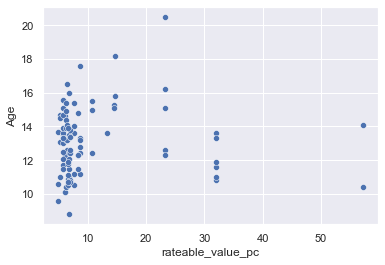

In [34]:
sns.scatterplot(x='rateable_value_pc',y='Age',data=data_merged)

### Spearman Correlation

Pearson correlation is one option of many to compute the strength of the relationship between two variables. The choice depends on your research priorities and some procedures will be more relevant or valid than others. 

Pearson takes into account the absolute counts of the number of cats and dogs. But imagine, that I don't care about how many animals I observe each day what matters is that ranking of the days is correlated. In this case, the ranking of the days has priority. In this scenario, we should calculate the Spearman rank correlation.  

To obtain this coefficient, we need to compute the rank of each day, for example, the third item in `v1` has rank 4 (i.e. it comes fourth after the items on positions 0, 1 and 4)

In [35]:
v1_ranked = {v:i+1 for i,v in enumerate(sorted(v1))} # compute the rank if each days
v1_rank = [v1_ranked[i] for i in v1]
v1, v1_rank 

([1, 3, 5, 7, 2, 6], [1, 3, 4, 6, 2, 5])

In [36]:
v2_ranked = {v:i+1 for i,v in enumerate(sorted(v2))} # compute the rank if each days
v2_rank = [v2_ranked[i] for i in v2]
v2, v2_rank

([2, 4, 8, 7, 3, 5], [1, 3, 6, 5, 2, 4])

In [37]:
mean_v1 = np.mean(v1_rank) # we compute the mean ranks
mean_v2 = np.mean(v2_rank)

In [38]:
nominator = np.sum([(i1 - mean_v1)*(i2 - mean_v2) for i1,i2 in zip(v1_rank,v2_rank)]) # we compute the difference between rank and mean rank

In [39]:
denominator = np.std(v1_rank) * np.std(v2_rank) * len(v2_rank)

In [40]:
nominator/denominator

0.8285714285714286

In [41]:
pd.Series(v1).corr(pd.Series(v2), method='spearman')

0.8285714285714287

In [42]:
data_merged['Age'].corr(data_merged['rateable_value_pc'],method='spearman')

0.10742706678948936

Correlation does not mean causation. Oftentimes, correlations are 'spurious', i.e. it is unlikely there exists a realistic mechanism that explains the association between two variables. 
 
There is even [a website on this topic!](https://www.tylervigen.com/spurious-correlations)

Be careful when making claims based on correlation. As often, the statistical experiment won't give you an answer to your question. There is no simple way to determine if a correlation is spurious. It depends on your domain expertise to make sense of these results and justify them.


# Linear Regression

Whereas correlation tells you that two variables, X and Y, are related you can not model their relationship, i.e. you can not predict Y using X. Correlation can only tell you that when X goes up, Y goes up (or not).

Regression modelling attempts to model the mechanistic relationship between two variables: how many cats do I expect to see, given that I observed five dogs?

Modelling the mechanistic relationship enables us to predict outcomes based on independent variables or predictors.

Returning to our example of age and wealth (goodbye doggies, you were helpful), we'd want to predict the lifespan (the response variable approximated by the ratio of residents older than 50) given the rateable value per capita (predictor variable).

Notice that we rely on domain expertise to construct a model that makes sense. We could also model the reverse, assuming that increasing lifespan will push rateable value upwards.

However, we assumed wealth has a positive impact on lifespan and not vice versa. Our causal model, therefore, looks as follows: 

`Wealth -> lifespan`

and not 

`Wealth <- lifespan`

Whether a causal model makes sense is not a statistical question but depends on your domain expertise as a historian (and in this case, there is room for dispute!?). When reading a historical paper that uses statistical methods, it is often more important to critically look at the relation between the narrative and the method than just the regression procedure: What are data supposed to capture and how are they combined into/framed as a causal theory?

Let's discuss these questions with some actual data. We first demonstrate what a regression model does before we continue with a more detailed explanation of how to run and evaluate a regression model.

A linear model tries to predict a value (lifespan/ratio of 50+) based on a linear combination of other variables (for now, just one, the rateable value per capita). We want to predict the former using the latter.

Using `seaborn` we can make a dispersion plot where each observation is turned into a point on the figure. The x-axis (`x=`) shows the rateable value, the y-axis (`y=`) the ratio of residents older than 50. 

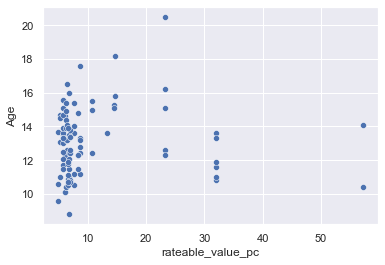

In [43]:
sns.scatterplot(x='rateable_value_pc',
                y='Age',
                data=data_merged)



A linear regression models the relation between `x` and `y` by drawing a line best "fits" the data, i.e. is closest to the observations as possible.


From your high school education, you may remember the equation of a line.

$y = a + b*x$


Which can convert this equation to our variables of interest

- $a$ is the intercept, the point where the line crosses to y-axis when x is zero. You may also think as: what ratio do we expect for a place with zero rateable value?

- $b$ is the slope, and determines the strength of the relationship between $y$ and $x$: how much change do we expect in $y$ after one unit change $x$. 



We know lifespan and rateable value. 

lifespan = intercept + slope * rateable value per capita

We use these data to estimate the values of $a$ (intercept) and $b$ slope. 
We will discuss later how, but for now, we just plot the outcome of running a linear regression, to show what the model thinks the line should look like after observing the data.

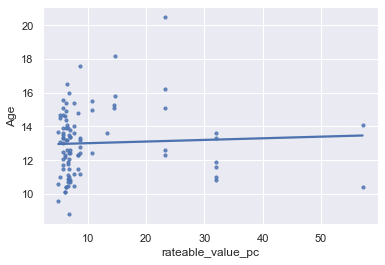

In [44]:
sns.regplot(x="rateable_value_pc", y="Age", 
                 data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

The line visualizes the outcome of linear regression. The fact that a model throws back a result, a line, doesn't necessarily mean that this result makes sense. The best fit can still be pretty bad. In this case, the line is pretty flat, suggesting that $b% is close to zero, but also pretty bad (it doesn't capture much of the variation).

As you observe there are many values are clustered together in the lower range of the x-axis, and only a few appear at the right-hand side of the figure.

We can improve the fit by transforming the values on x-axis. We take the natural logarithm of the rateable value per capita, this will make small differences bigger and bigger ones smaller, it pulls apart the observation at the lower end of the independent variable and pushes those placed at the far right towards the other observations).

But what is the natural logarithm? Let's have a look, what happens if we take the logarithm of 1000

In [45]:
np.log(1000)

6.907755278982137

We get a number close to 7 (i.e. 6.907755278982137). What does this mean? The logarithm is inverse of exponentiation: if x = log(y) then y = exp(x), or sticking to our example, if np.log(1000) produces 6.907755 then 
e<sup>6.90775</sup> will approximately equal 1000 (not exactly as rounded the numbers.
`e` is called Euler's number and is approximately equal to 2.71828182845904523536028747135266249775724709369995 according to [Wikipedia](https://en.wikipedia.org/wiki/E_(mathematical_constant)). You can check this for yourself

In [46]:
np.exp(6.907755278982137)

999.9999999999998

..is equivalent to...

In [47]:
np.power(2.71828,6.907755278982137)

999.9953534904313

But why would we do this? Why would we effectively rescale our variables? Taking the logarithm partly solves the problem of dispersion:  the logarithmic scale makes linear modelling often easier if a  variable is linear on the logarithmic scale. 

In [48]:
x_1 = [10,100,1000,10000]

It is difficult to model these gaps with a line...

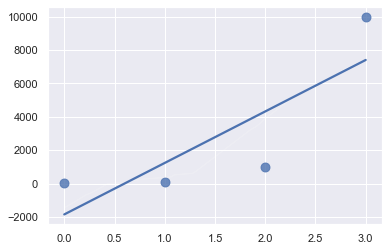

In [49]:
sns.regplot(x=list(range(len(x_1))), y=x_1, 
                 scatter_kws={"s": 80},
                 order=1,ci=False)

However, on a logarithmic scale, these values become neatly fit a line.

In [50]:
x_2 = np.log([10,100,1000,10000])

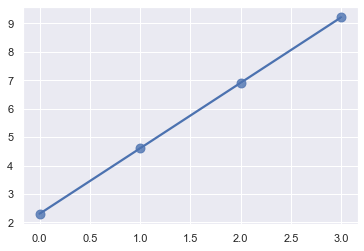

In [51]:
sns.regplot(x=list(range(len(x_2))), y=x_2, 
                 scatter_kws={"s": 80},
                 order=1,ci=False)

Even though 'real' data never fits a pattern as neatly, we observe similar changes when inspecting the rateable value per capita variable.

In [52]:
data_merged.sort_values('rateable_value_pc',inplace=True)

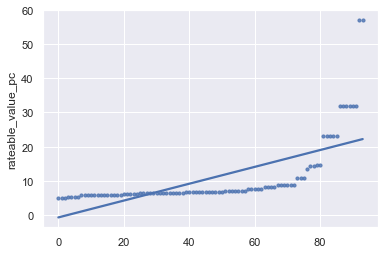

In [53]:
sns.regplot(x=list(range(len(data_merged))), y=data_merged["rateable_value_pc"], 
                 scatter_kws={"s": 10},
                 order=1,ci=False)

In [54]:
data_merged['rvc_log'] = np.log(data_merged['rateable_value_pc'])

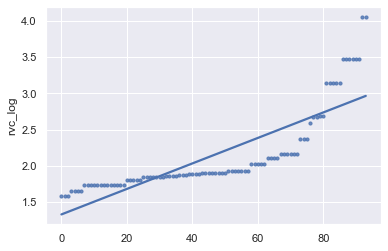

In [55]:
sns.regplot(x=list(range(len(data_merged))), y=data_merged["rvc_log"], 
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Both lines don't fit the data perfectly, However, the latter one seems to approximate the actual observed values better.

Also, if now model age as a function of the logged rateable value, the line will fit our observation better across all values of the x-axis. Still the result isn't great...

In [56]:
data_merged['rvc_log'] = np.log(data_merged['rateable_value_pc']) # take the logarithm of rvc

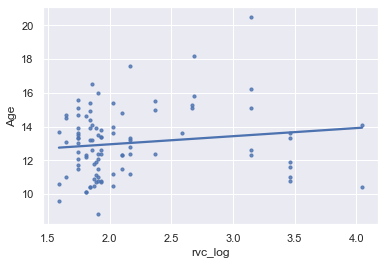

In [57]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Later we will quantify goodness of fit of the different lines (before and after taking the logarithm). For now, a visual inspection suffices. 

(Please notice that logging also improve the correlation between the two variables.)

In [58]:
data_merged['rateable_value_pc'].corr(data_merged['Age'],method='pearson')

0.04778305105124528

In [59]:
data_merged['rvc_log'].corr(data_merged['Age'],method='pearson')

0.13820568259755875

Taking the logarithm values doesn't harm, but you'll have to be careful as it influences your interpretation of the results and the predictions of the model. 

A closer look at the scatterplot and the data show that two (maybe ever three) places have a significantly higher rateable value: Holborn and Westminster, and also Marylebone. This is confirmed by the boxplot below.  


In [60]:
rvc.sort_values(by='rateable_value_pc',ascending=False)

,borough,rateable_value_pc
26,Westminster,57.2
12,Holborn,32.0
19,Marylebone,23.2
4,Chelsea,14.7
14,Kensington,14.4
6,Finsbury,14.2
11,Hampstead,13.3
17,Paddington,10.7
20,Pancras,8.7
1,Bermondsey,8.5


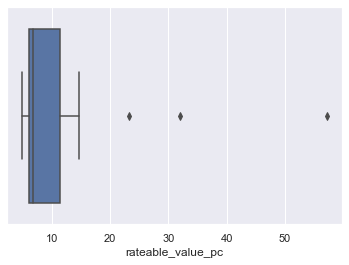

In [61]:
sns.boxplot(rvc.rateable_value_pc)


How to approach these observations: one easy, albeit problematic, approach is to consider them as "outliers" and remove them from the datasets.

This is a classical example of where interventions need to be motivated or at least explained by domain expertise. 

Let's remove these districts to understand the extent to which they affect our model and more importantly our understanding of the effect of wealth on lifespan. As you'll notice, the figure below suggests that after excluding  Holborn and Westminster, the relation become positive. These two districts have a large effect on the slope of the regression line.

In [62]:
data_wo_outliers = data_merged[~data_merged.borough.isin(['Westminster',"Holborn","Marylebone"])]

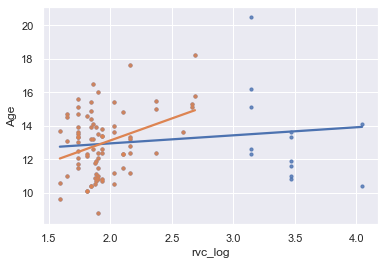

In [63]:
sns.regplot(x="rvc_log", y="Age", data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

sns.regplot(x="rvc_log", y="Age", data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

The orange line shows the impact of removing the so-called 'outliers'. Throwing away information (i.e. observations) is a tricky thing: yes, it becomes easier to model the relationship between the variables linearly. However, this "solution" comes at a cost, we won't be able to accurately say something about the wealthier districts. If we were to believe the orange line, we'd disastrously overestimate the ratio of older residents in districts like Westminster.

However, if you're only interested in predicting the age for a certain type of boroughs, and have good reasons to believe that the other ones away are qualitatively different (and deserve to be treated as separate case studies) than discarding observations is to some extent justifiable (but, of course, this should be made explicit).

In any case, we need to acknowledge that a few places carry a lot of weight in determining the outcome and interpretation of the regression model (they influence the estimate of the slope substantially).

Again, domain expertise has priority over statistics: the latter alone can not tell you what is the right approach.

In [64]:
print(data_merged['rvc_log'].corr(data_merged['Age']))
print(data_wo_outliers['rvc_log'].corr(data_wo_outliers['Age']))

0.13820568259755875
0.34931346861521706


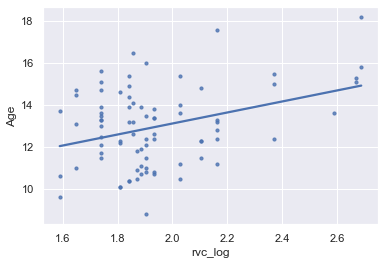

In [65]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Hopefully, this visual introduction demonstrated the use of linear regression and some of the problems that you are likely to encounter. Again, we'd like to stress that often the solution to these issues often require you to lean on your domain expertise as a historian. To solutions are often not statistical. 

History always should come before statistics.

The regression model attempts to capture as much as possible variation by drawing a straight line as close as to all the observations. However, the line doesn't have to be straight: this was a choice we made to constrain our model. We could have used, what is called, a "quadratic function" (i.e. $y$ = $a$ + $b$*$x$ + $c$*$x$<sup>2</sup>) to obtain a curve. Below we plot the quadratic approximation for the complete (blue) as well as the reduced (orange) data.


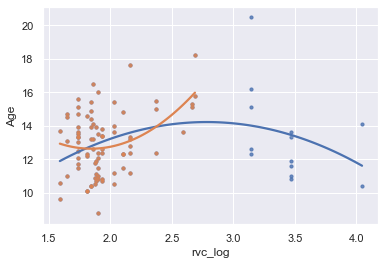

In [66]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_merged,
                 scatter_kws={"s": 10},
                 order=2,ci=False)
sns.regplot(x="rvc_log", y="Age", 
                 data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=2,ci=False)

## Linear Regression (a closer look)

In the preceding section, we introduced linear regression from a more visual, intuitive perspective. We did not discuss how to fit and read the results. 
Let's, therefore, have a closer look at the statistical nitty-gritty of regression analysis. Running a linear regression model is rather straightforward with the `statsmodels` package in Python. There a just a few things to be careful about. First, we define the response variable, in this case 'Age'.

In [67]:
Y = data_merged['Age']

Next, we select the independent variable from the dataframe.

In [68]:
X = data_merged['rateable_value_pc']

Now there is one small trick to keep in mind. The equation of a simple linear model is:

$y = a + b*x$

Both $y$ and $x$ are data we observed. We don't know $a$ and $b$, these are the parameters we want to learn from the data. Running a regression will return an estimate for $a$ and $b$ that is most consistent with the observed data. 

Because we want `statsmodels` to estimate both the intercept $a$ and the slope $b$ we have to add one more column with only a constant to `X`. Luckily this is really straightforwards with the `add_constant` function.

In [69]:
X = sm.add_constant(X)
X.head()

,const,rateable_value_pc
0,1.0,4.9
1,1.0,4.9
2,1.0,4.9
3,1.0,5.2
4,1.0,5.2


Now we are ready to fit the model. 'Fitting the model' means finding the optimale fit with the data, in our case we estimate the parameters for a line (intercept and slope) that best capture the variation in our data. Please notice that a line may not necessarily provide 

We save the fitted model in the `results` variable.

In [70]:
model = sm.OLS(Y,X) # instantiate model
results = model.fit() # fit model

Applying the `.summary()` method to the fitted model will print a report.

In [71]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.2105
Date:                Wed, 02 Feb 2022   Prob (F-statistic):              0.647
Time:                        23:33:14   Log-Likelihood:                -198.53
No. Observations:                  94   AIC:                             401.1
Df Residuals:                      92   BIC:                             406.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.9145      0.307     42.037      0.000      12.304      13.525
rateable_value_pc     0.0097      0.021      0.459      0.647      -0.032       0.052
==============================================================================
Omnibus:                        9.979   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.252
Skew:                           0.662   Prob(JB):                      0.00594
Kurtosis:                       3.929   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The most important parts of this (admittedly extensive) report are located at the top right (`R-squared`) and in the middle (`const` and `rvc_log`). Let's start with the latter. These numbers will figure most prominently in the interpretation of the results.


- `const 12.9145` means that for a place with zero rateable value, we expect the percentage of those over 50 to be around 12.9. This is the estimate for the intercept, i.e. the value of y (Age) when x (rateable value) = 0. 
- `rateable_value_pc 0.0097	` is an estimate of the slope which is the increase in y for one unit change in x. For example: if the rateable value changes from 1 to 2 we expect an increase of 0.0097% (not a lot in other words). 
- What do the other statistics reported tell us about these coefficients? Continuing with the estimate for `rateable_value_pc` the p-value is around 0.65, substantially higher than the traditional 0.05 threshold. So far there is a weak positive association, it is unlikely to be of any significance. 
- The confidence intervals range from `-0.032` to `0.052`. Notice that zero is included in the confidence interval. A slope of zero implies a horizontal line, meaning no change in y for x (they are largely independent, x does not influence y at all!). The chance that x and y are not related (in any positive or negative way) is well within the range of possibilities.
- p-values and confidence intervals remain rather abstract and difficult to explain, and statisticians tend to doubt their use. In human language, these number tells you how sure the model is about where to draw the line. It is really sure that the intercept is higher than zero, which is not surprising. However, it is less confident about the slope, which can go down (-0.032) as well as up (0.052).

What happens if we fit a new model with logged rateable values?

In [72]:
Y_2 = data_merged['Age']
X_2 = data_merged['rvc_log']
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(Y_2,X_2) # instantiate model
results_2 = model_2.fit() # fit model

In [73]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.791
Date:                Wed, 02 Feb 2022   Prob (F-statistic):              0.184
Time:                        23:33:14   Log-Likelihood:                -197.73
No. Observations:                  94   AIC:                             399.5
Df Residuals:                      92   BIC:                             404.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9857      0.799     15.010      0.000      10.400      13.572
rvc_log        0.4809      0.359      1.338      0.184      -0.233       1.194
==============================================================================
Omnibus:                        7.154   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.612
Skew:                           0.573   Prob(JB):                       0.0367
Kurtosis:                       3.614   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using the log-scale changes coefficients quite a lot (especially for the rateable value). To coefficient is higher (we expect 0.5% change in y for a unit change in x). Nonetheless, the p-value suggests that this positive association may still be the result of random chance. The model is now more certain the relation is positive but still includes zero within the 95% confidence interval. 

Note that the scale of the x-axis is different now. For each change in x, the logged rateable value, we expect to add half a percentage to y. The steps on x-axis are become increasingly large on the original scale of rateable value.

In [74]:
np.exp(2), np.exp(3), np.exp(4)

(7.38905609893065, 20.085536923187668, 54.598150033144236)

According to the model, the rate of change in lifespan is the same when moving from 7 to 20 or transitioning from 20 to 54.

As said, the additional statistics for each coefficient convey where the model thinks the line should be.

Similar to notebook 10, We can make these results more intuitive using a "bootstrap" method. We construct the mean and confidence intervals by resampling from the original data. 

More precisely, we repeat the following steps, let's say, 1000 times:
- sample observations from the data (50% at each iteration)
- fit the model and record the values for the intercept and the slope
- plot the lines using these recorded values (or collect them and compute the 2.5 and 97.5 percentile range).

This procedure is implemented by the code below (only 100 iteration but feel free to change this).

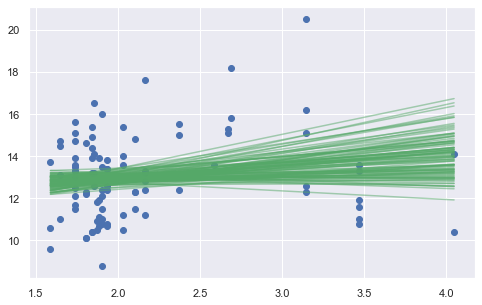

In [75]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter('rvc_log', 'Age',data=data_merged)
 
for _ in range(100): # repeat 100 times
    dms = data_merged.sample(frac=.5) # sample observations from the data
    Y_ = dms['Age'] # get the response variable
    X_ = dms['rvc_log'] # get the independent variable
    X_ = sm.add_constant(X_) # add constant used for estimating the intercept
    
    model_ = sm.OLS(Y_,X_) # instantiate the model
    results_ = model_.fit()  # fit the model
    x = data_merged['rvc_log'] # get values for the x-axis
    y = results_.params['const'] + (data_merged['rvc_log']*results_.params['rvc_log']) # y-axis value
    ax.plot(x,y , '-g',alpha=.5)


The values are not the same because we have a small sample and only ran a few iterations. However, it gives a more intuitive way of understanding what the p-values and confidence intervals of the coefficients mean. 

The "bowtie" shape is very common when plotting the outcome of a regression model: the model is fairly certain the line has to go through the mean but becomes more uncertain at the extremes because it lacks data.

Instead of bootstrapping, you can compute the confidence intervals directly with `statsmodels`. In the figure below we plot the predictions (red) together with the confidence intervals (green).

In [76]:
pred = results_2.get_prediction(X_2) # get predictions
df_pred = pd.DataFrame(pred.conf_int()) # get confidence interval from predictions
df_pred['mean'] = pred.predicted_mean # get the predicted values

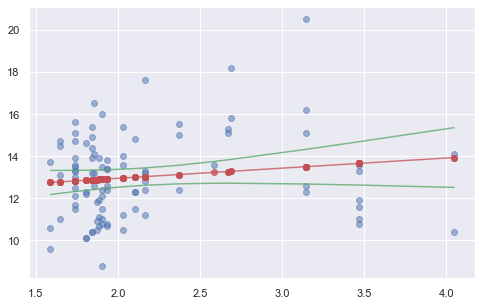

In [77]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter('rvc_log', 'Age',data = data_merged,alpha=.5) # plot logged rvs versus age
ax.plot(data_merged['rvc_log'], df_pred['mean']  , '-ro',alpha=.75) # plot the predictions
ax.plot(data_merged['rvc_log'], df_pred[0]  , '-g',alpha=.75) # plot the lower bound of the confidence intervals
ax.plot(data_merged['rvc_log'], df_pred[1]  , '-g',alpha=.75) # plot the upper bound of the confidence intervals

Please notice that coeficients and their confidence intervals are estimates of the line not the actual data. These are, as you can see, well outside the range given by the predicted values and their confidence intervals.

The `.summary()` method provides other statistics that help you understanding how well the model performs.

In [78]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.791
Date:                Wed, 02 Feb 2022   Prob (F-statistic):              0.184
Time:                        23:33:15   Log-Likelihood:                -197.73
No. Observations:                  94   AIC:                             399.5
Df Residuals:                      92   BIC:                             404.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9857      0.799     15.010      0.000      10.400      13.572
rvc_log        0.4809      0.359      1.338      0.184      -0.233       1.194
==============================================================================
Omnibus:                        7.154   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.612
Skew:                           0.573   Prob(JB):                       0.0367
Kurtosis:                       3.614   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lastly, we can see what happens when we remove the influential observations or outliers. The estimate for the slope is positive, with a p-value well below 0.05. The model is confident that the association is positive, and generally, knows better where to position the line. This is also reflected in the bootstrap: the lines are tighter packed than in the previous experiments and tend not to go in unpredictable directions.

In [79]:
Y_woo = data_wo_outliers['Age']
x_woo = data_wo_outliers['rvc_log']
#X_woo = np.column_stack((x_woo, np.log(data_wo_outliers['index'])))
X_woo = sm.add_constant(x_woo)
model_3 = sm.OLS(Y_woo,X_woo)
results_3 = model_3.fit()

In [80]:
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     10.98
Date:                Wed, 02 Feb 2022   Prob (F-statistic):            0.00139
Time:                        23:33:15   Log-Likelihood:                -160.58
No. Observations:                  81   AIC:                             325.2
Df Residuals:                      79   BIC:                             329.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8738      1.550      5.081      0.000       4.789      10.958
rvc_log        2.6244      0.792      3.313      0.001       1.048       4.201
==============================================================================
Omnibus:                        2.637   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                1.865
Skew:                           0.177   Prob(JB):                        0.394
Kurtosis:                       2.346   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

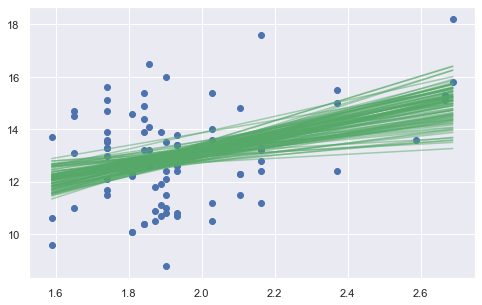

In [81]:
data_wo_outliers.sort_values('rvc_log',inplace=True)
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter('rvc_log', 'Age',data=data_wo_outliers)
beta = []
for _ in range(100):
    dms = data_wo_outliers.sample(frac=.5)
    Y_ = dms['Age']
    X_ = dms['rvc_log']
    X_ = sm.add_constant(X_)
    model = sm.OLS(Y_,X_)
    results = model.fit() 
    beta.append(results.params['rvc_log'])

    ax.plot(data_wo_outliers['rvc_log'], results.params['const'] + (data_wo_outliers['rvc_log']*results.params['rvc_log']) , '-g',alpha=.5)


Before we close this chapter, we need to discuss a more important statistic reported in the regression summary: the R-squared. This score varies between 0 and 1 and indicates how well our model fits the data, with 1 meaning a perfect fit. You'll notice that R-squared in the summary of `results_2` is lower compared to the output of `results_3` (after removing the outliers).

In [82]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.791
Date:                Wed, 02 Feb 2022   Prob (F-statistic):              0.184
Time:                        23:33:15   Log-Likelihood:                -197.73
No. Observations:                  94   AIC:                             399.5
Df Residuals:                      92   BIC:                             404.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9857      0.799     15.010      0.000      10.400      13.572
rvc_log        0.4809      0.359      1.338      0.184      -0.233       1.194
==============================================================================
Omnibus:                        7.154   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.612
Skew:                           0.573   Prob(JB):                       0.0367
Kurtosis:                       3.614   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     10.98
Date:                Wed, 02 Feb 2022   Prob (F-statistic):            0.00139
Time:                        23:33:15   Log-Likelihood:                -160.58
No. Observations:                  81   AIC:                             325.2
Df Residuals:                      79   BIC:                             329.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8738      1.550      5.081      0.000       4.789      10.958
rvc_log        2.6244      0.792      3.313      0.001       1.048       4.201
==============================================================================
Omnibus:                        2.637   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                1.865
Skew:                           0.177   Prob(JB):                        0.394
Kurtosis:                       2.346   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In general, the R-squared is helpful when comparing models, but we should not attach too much importance to this score: a good fit doesn't necessarily mean that we capture and understand the (causal) mechamism of interest accurately. Firstly, we could simple add more predictors and after while we can almost perfectly fit the data. For example instead of quadratic, a polynomial of order 2, we can fit our data with polynomial of order 20. This will fit the data perfectly but doesn't learn us anything about the relation between our variables of interests. Also the weird squigly lines don't make sense and will make very poor and blatantly unrealistic predictions (a negative percentage -200 for place with a logged rateable value of 2.5. This models overfits the data. Secondly, there is a distinction between prediction and inference. Being good at perdiction, doesn't imply that the model captures the causal mechanism (or the data generation process) adequately. More intelligents thoughts about the difference between prediction and inference are available in Statistical Rethinking or consult this blog post.

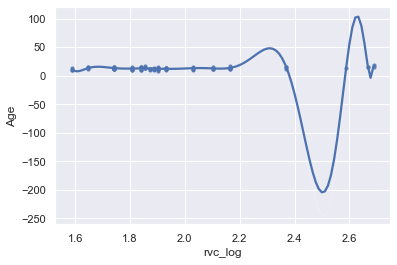

In [84]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=20,ci=False)

This detour aside, we close this notebook with computing R-squared by hand to give you an intuition of the meaning of this statistic.

`RMSE`: First we compute the root mean squared prediction error. For each data point, 

In [85]:
Y_hat = results_2.predict() # get predicted values
Y = data_merged['Age'] # get observed values

In [86]:
 
var_pred = np.sum([(y - y_hat)**2 for y,y_hat in zip(Y,Y_hat)]) # difference between observed and predicted by the power of two
rmse = np.sqrt(var_pred / len(Y)) # sum all values, divide by the number of observations and take the square root
rmse 

1.9828586340496166

`R-squared`: 
- we compute the variation between observed and predicted values (`var_pred`) 
- we compute the total variation by subtracting the observed value with the mean.

In [87]:
var_total = np.sum([(y - np.mean(Y))**2 for y,y_hat in zip(Y,Y_hat)] )

Then we divided `var_pred` by `var_total`. 

In [88]:
var = var_pred / var_total

To make sure the number ranges between 0 (minimum) and 1 (maximum), we simply calculate `1 - var`.

In [89]:
round(1 - var ,3)

0.019

# Fin.